# 深圳签订外贸合同量预测ARIMA模型

## 使用到的模块及其安装

 - Python version: 3.11.0
 - Pandas version: 2.2.3
    - pip install pandas==2.2.3
 - Matplotlib version: 3.10.1
    - pip install matplotlib==3.10.1
 - Statsmodels version:
    - pip install statsmodels==0.14.4

In [16]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
df=pd.read_excel('深圳签订外贸合同项数数据1990~2023.xlsx')
# 中国香港、澳门 | 中国台湾	| 新加坡 | 韩国 | 日本 | 泰国 | 澳大利亚 | 马来西亚 | 美国 | 加拿大 | 德国 | 法国 | 英国 | 瑞士 | 荷兰 | 其他
# df.head(5)

df_total = df.drop(df.columns[2: 17], axis=1)
# df_total = df.drop(columns=['进口（亿元人民币）', '出口（亿元人民币）'], axis=1) # 保留单一列数据，用于预测。这里以进出口总额的预测为例。
print('原数据预览：\n', df.head())
print('保留后数据预览：\n', df_total.head())

原数据预览：
      时间  中国香港、澳门  中国台湾  新加坡   韩国   日本   泰国   澳大利亚   马来西亚   美国   加拿大   德国   \
0  1990      699    45     5    0   12    2      2      1   16     2    0   
1  1991      885    36     8    3   17    3      1      0   18     2    2   
2  1992     1330    88    20    5   16    8      6      3   57     8    1   
3  1993     2834   154    24    8   27   15     14      5  104    22    2   
4  1994     1885   124    29    8   25    8      7      3   74    10    5   

   法国   英国  瑞士   荷兰  其他  
0    1   2    3   0   6  
1    3   2    1   1   4  
2    2   5    0   1  11  
3    4  16    2   3  23  
4    3  19    0   1  22  
保留后数据预览：
      时间  中国香港、澳门
0  1990      699
1  1991      885
2  1992     1330
3  1993     2834
4  1994     1885


## 进出口总额预测处理

In [18]:
# 修改列标题
df_total.columns = ["时间", "数据"]
# 转化月份为时间数据
# df_total['时间']=pd.to_datetime(df['时间'])
# 转化时间数据为 datetime 对象
df_total['时间'] = pd.to_datetime(df_total['时间'], format='%Y')

# 设置时间索引
df_total.set_index('时间', inplace=True)
df_total.head()

,数据
时间,
1990-01-01,699
1991-01-01,885
1992-01-01,1330
1993-01-01,2834
1994-01-01,1885


In [19]:
# 获取数据描述
df_total.describe()

,数据
count,34.000000
mean,2573.117647
std,2306.554991
min,699.000000
25%,1472.500000
50%,1966.500000
75%,2808.000000
max,13703.000000


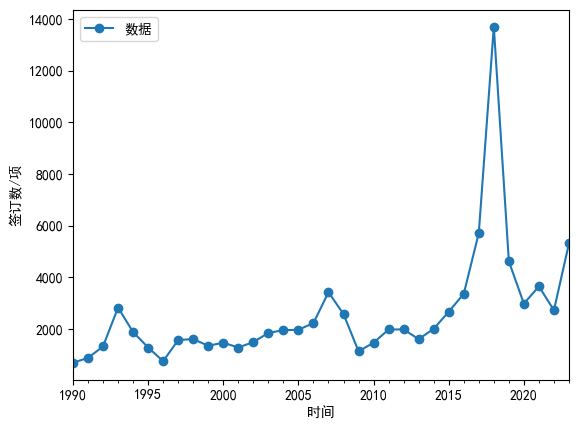

In [20]:
# 原始数据可视化绘图
df_total.plot(kind='line', marker='o')
plt.ylabel('签订数/项')
plt.show()

In [21]:
# ADF 检验函数
# H0：它是非平稳的  
# H1：它是平稳的
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF检验统计量', 'p值', '使用的滞后数', '使用的观测值数量']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。")
    else:
        print("反对零假设的弱证据，时间串行有一个单位根，表明它是非平稳的。")

In [22]:
# ADF 检验1：原始数据不平稳
adfuller_test(df_total['数据'])

ADF检验统计量 : -3.1721600862949275
p值 : 0.021653784006136444
使用的滞后数 : 0
使用的观测值数量 : 33
反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。


In [23]:
# 差分操作
df_total['一阶差分'] = df_total['数据'] - df_total['数据'].shift(1)   # 一阶差分
# df_total['季节性差分'] = df_total['数据']-df_total['数据'].shift(12)  # 季节性差分
df_total.head(14)

,数据,一阶差分
时间,,
1990-01-01,699,NaN
1991-01-01,885,186.0
1992-01-01,1330,445.0
1993-01-01,2834,1504.0
1994-01-01,1885,-949.0
1995-01-01,1288,-597.0
1996-01-01,760,-528.0
1997-01-01,1576,816.0
1998-01-01,1614,38.0


In [24]:
# ADF 检验2：经过差分处理后已经平稳
print("一阶差分：")
adfuller_test(df_total['一阶差分'].dropna())
# print("\n季节性差分：")
# adfuller_test(df_total['季节性差分'].dropna())

一阶差分：
ADF检验统计量 : -3.4519359805971517
p值 : 0.00931076586263661
使用的滞后数 : 8
使用的观测值数量 : 24
反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。


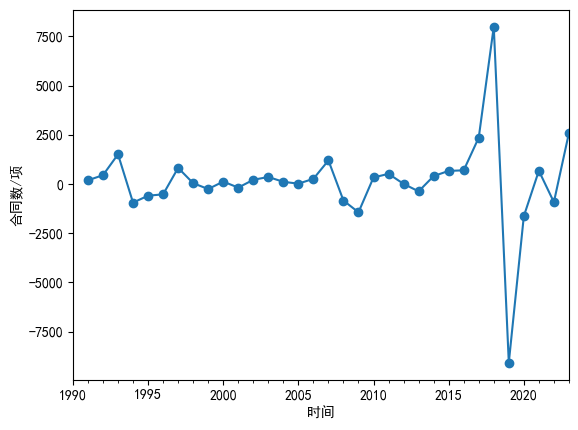

In [25]:
# 绘制可视化图像
df_total['一阶差分'].plot(kind='line', marker='o')
plt.ylabel('合同数/项')
plt.show()

# df_total['季节性差分'].plot(kind='line', marker='o')
# plt.ylabel('合同数/项')
# plt.show()

### 自动回归模型


自回归模型（AR模型）的一般形式：

$$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t $$

其中：
- $ y_t $ 是时间序列在时间 t 的值。
- $ c $ 是常数项。
- $ \phi_1, \phi_2, \ldots, \phi_p $ 是模型参数，分别代表不同滞后项的系数。
- $ y_{t-1}, y_{t-2}, \ldots, y_{t-p} $ 是时间序列在 t-1, t-2, ..., t-p 时刻的值，即滞后项。
- $ \varepsilon_t $ 是误差项，通常假设为白噪声序列。
- $ p $ 是模型的阶数，表示考虑的滞后项的数量。

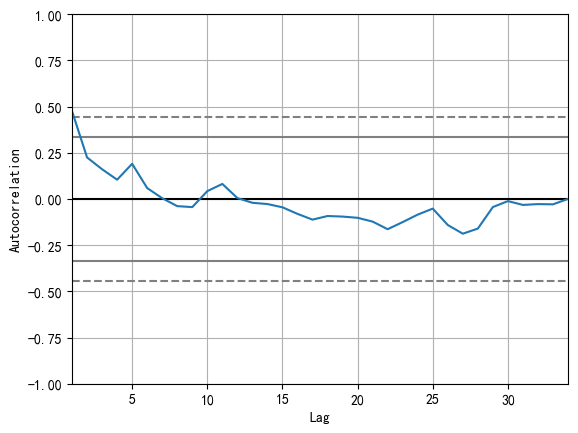

In [26]:
# 绘制自相关图
autocorrelation_plot(df_total['数据'])
plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 20 must be < 16.

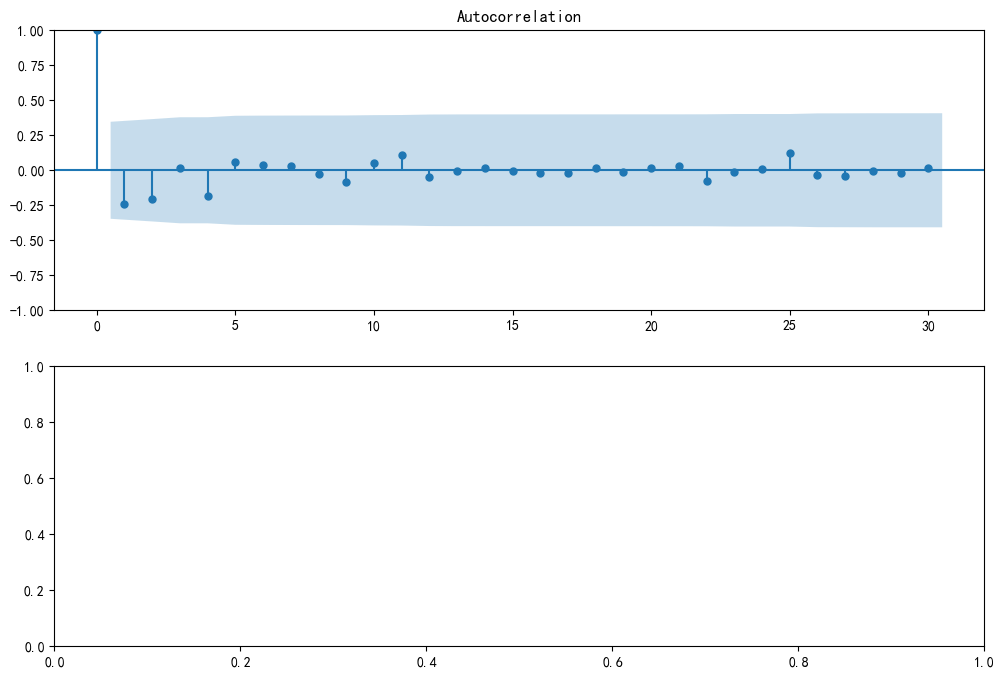

In [28]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(211)
fig1 = plot_acf(df_total['一阶差分'].iloc[2:], lags=30, ax=ax1)   # 绘制自相关函数（ACF）图
ax2 = fig1.add_subplot(212)
fig1 = plot_pacf(df_total['一阶差分'].iloc[2:], lags=20, ax=ax2)  # 偏自相关函数（PACF）图

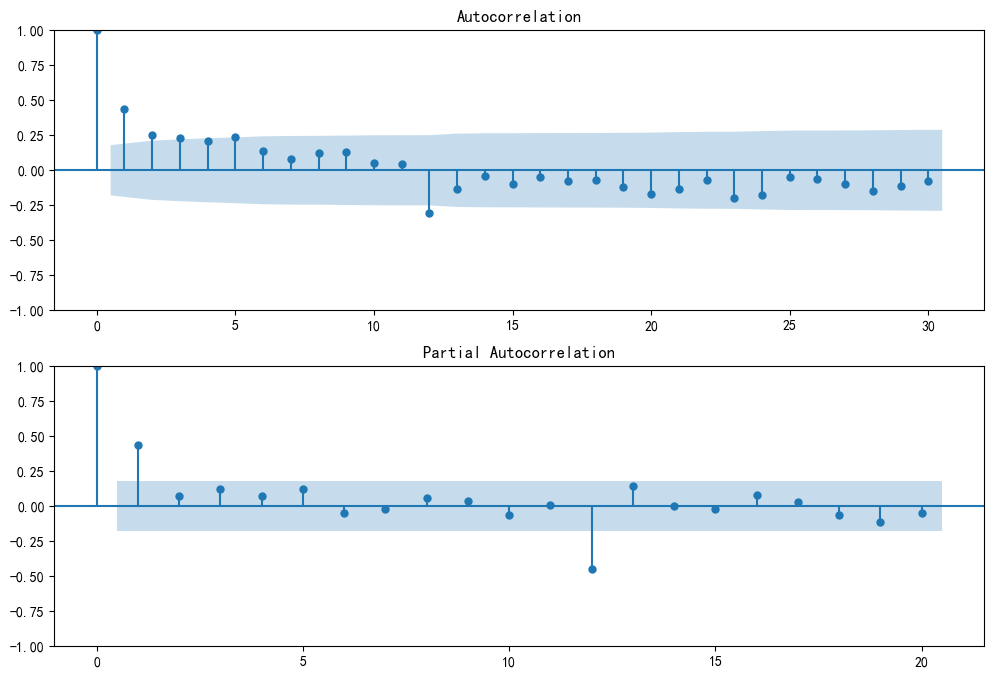

In [13]:
fig1 = plt.figure(figsize=(12, 8))
ax1 = fig1.add_subplot(211)
fig1 = plot_acf(df_total['季节性差分'].iloc[13:], lags=30, ax=ax1)   # 绘制自相关函数（ACF）图
ax2 = fig1.add_subplot(212)
fig1 = plot_pacf(df_total['季节性差分'].iloc[13:], lags=20, ax=ax2)  # 偏自相关函数（PACF）图

### 拟合

e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='时间'>

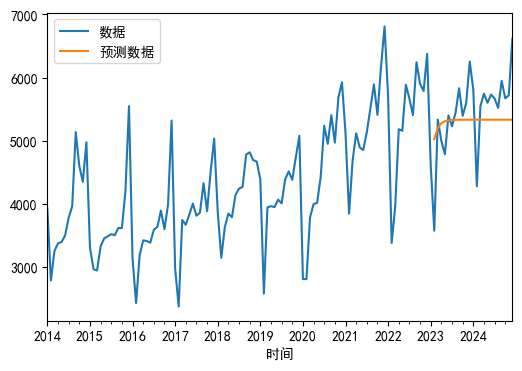

In [14]:
# 一阶差分ARIMA模型
# 使用ARIMA模型对数据进行建模，其中包含一阶差分以使数据平稳
model_one = ARIMA(df_total['数据'], order=(1, 1, 1), freq='MS')
one_fit = model_one.fit()

# 使用拟合后的模型进行预测
df_total['预测数据'] = one_fit.predict(start=109, end=132, dynamic=True)
df_total[['数据', '预测数据']].plot(figsize=(6, 4))

e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='时间'>

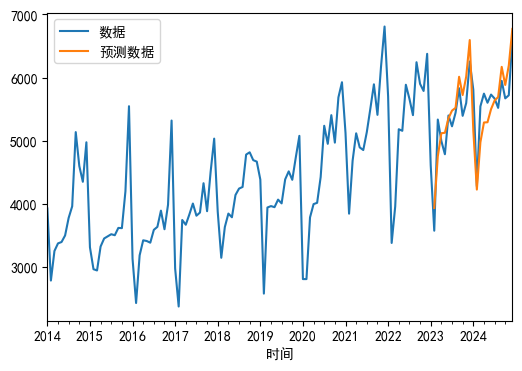

In [15]:
# 季节性差分SARIMAX模型
model_seasonal = sm.tsa.statespace.SARIMAX(df_total['数据'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), freq='MS')
seasonal_fit = model_seasonal.fit()

# 季节性差分绘图
df_total['预测数据'] = seasonal_fit.predict(start=109,end=132,dynamic=True)
df_total[['数据','预测数据']].plot(figsize=(6,4))

In [16]:
future_dates=[df_total.index[-1]+ DateOffset(months=x)for x in range(1,25)]
future_datest_df=pd.DataFrame(index=future_dates[0:],columns=df_total.columns)

In [17]:
# 季节性差分SARIMAX模型的拟合效果更佳
future_df=pd.concat([df_total,future_datest_df])
future_df['预测数据'] = seasonal_fit.predict(start = 132, end = 155, dynamic= True)
future_df.tail()

C:\Users\31561\AppData\Local\Temp\ipykernel_32860\725069066.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df_total,future_datest_df])


,数据,一阶差分,季节性差分,预测数据
2026-08-01,NaN,NaN,NaN,5925.411873
2026-09-01,NaN,NaN,NaN,6388.095782
2026-10-01,NaN,NaN,NaN,6088.906820
2026-11-01,NaN,NaN,NaN,6366.645449
2026-12-01,NaN,NaN,NaN,6982.311898


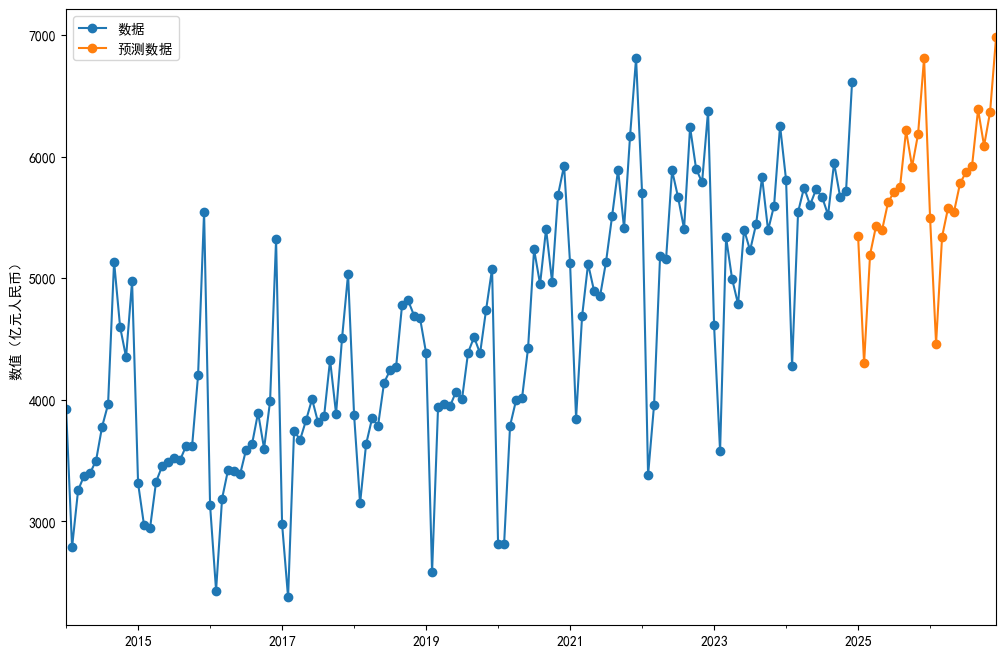

In [18]:
future_df[['数据', '预测数据']].plot(figsize=(12, 8), kind='line', marker='o') 
plt.ylabel('数值（亿元人民币）')
plt.show()

In [19]:
# 保存时间和预测数据列到Excel文件
future_df.to_excel('end_out.xlsx')